In [1]:
%load_ext rpy2.ipython
%matplotlib inline

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
from scipy import stats
import sympy as sym
from IPython.display import Image

plt.rcParams['figure.figsize'] = (20, 7)


# Rare-event simulation
## Lecture 2
### Patrick Laub, Institut de Science Financière et d’Assurances

## Agenda

- Finish cross-entropy method
- Exponential tilting
- Acceptance-rejection sampling
- Markov chains
- Markov chain Monte Carlo

- Go over solutions to last week's quiz

 ## Cross-entropy method
 
__Iteratively__ finds better importance sampling distributions, by minimising the distance between the current guess to the __optimal IS distribution__.

Example: find $\mathbb{P}(Z > 5)$ for $Z \sim \mathsf{Normal}(0, 1)$, using IS with proposal distributions which are $\mathsf{Normal}(\mu, \sigma^2)$.

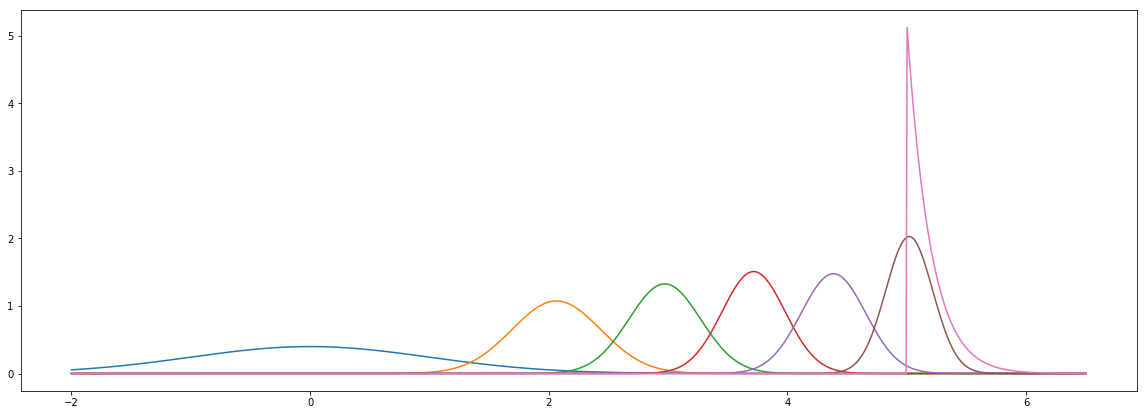

In [5]:
fig, ax = plt.subplots(figsize=(20, 7))

xs = np.linspace(-2, 6.5, 1000)
ys = [dist.pdf(xs) for dist in propDistHistory]
ys.append( origDist.pdf(xs) * (xs > γ) / (1 - origDist.cdf(γ)) )

ax.plot(xs, np.array(ys).T);

 ## Cross-entropy method: high level
 
 
 1. Choose a family of distributions to search inside for the best IS proposal, $f( \,\cdot\,  ; \boldsymbol{\theta})$.
 2. Choose some distribution in the family as the starting point, $f( \,\cdot\, ; \boldsymbol{v}_{\ 0})$.
 3. Iteratively construct a better proposal $\boldsymbol{v}_i$ based on the previous $\boldsymbol{v}_{i-1}$ by stepping closer to the optimal $g^*$.
 4. When this converges to some $\boldsymbol{v}_*$, return the result of IS with $f( \,\cdot\, ; \boldsymbol{v}_*)$ proposal.

 ## Cross-entropy method: details
  
 1. Choose a family $f( \,\cdot\, ; \boldsymbol{\theta})$, a starting point $\boldsymbol{v}_{\,0}$, $R$ (e.g. $R=10^6$), and $\rho$ (e.g. $\rho = 0.10$).
 2. For $i=1, 2, \dots$:
     1. Simulate $X_r \overset{\mathrm{i.i.d.}}{\sim} f( \,\cdot\, ; \boldsymbol{v}_{i-1})$  for $r=1,\dots,R$.
     2. Find the quantile $\gamma_i = \mathrm{Quantile}( \{ X_1, \dots, X_R\} , 1-\rho)$.
     3. If $\gamma_i \ge \gamma$, set $\boldsymbol{v}_* = \boldsymbol{v}_{i-1}$, and quit the loop.
     3. Set
     $$
     \DeclareMathOperator*{\argmax}{arg\,max}
     \boldsymbol{v}_{i} = \argmax_{\boldsymbol{v}} \frac{1}{R} \sum_{r=1}^R 1\{ X_r > \gamma_i \} \frac{f(X_r)}{f(X_r; \boldsymbol{v}_{i-1})} \log \bigl[ f(X_r; \boldsymbol{v}) \bigr]
     $$
     by letting $\boldsymbol{v}_{i}$ be the solution to
     $$ \sum_{r=1}^R 1\{ X_r > \gamma_i \} \frac{f(X_r)}{f(X_r; \boldsymbol{v}_{i-1})} \nabla_{\hspace{-5px}\boldsymbol{v}} \Bigl\{ \log \bigl[ f(X_r; \boldsymbol{v}) \bigr] \Bigr\} = \boldsymbol{0} .$$
 3. Return the result of IS with $f( \,\cdot\, ; \boldsymbol{v}_*)$ proposal.

### Worked example: Exponential distributions

Example, $f(x ; \theta) = \frac{1}{\theta} \mathrm{e}^{-\frac{x}{\theta}}$, i.e., $f( \,\cdot\, ; \theta)$ is $\mathsf{Exponential}(\frac{1}{\theta})$.

Say that we've simulated $X_r \overset{\mathrm{i.i.d.}}{\sim} f( \,\cdot\, ; v_{i-1})$ for $r=1,\dots,R$.
Want to find $v_i$ be the solution to

$$ \sum_{r=1}^R 1\{ X_r > \gamma_i \} \frac{f(X_r)}{f(X_r; v_{i-1})} \frac{\mathrm{d}}{\mathrm{d} v} \Bigl\{ \log \bigl[ f(X_r; v) \bigr] \Bigr\} = 0 .$$


$$ 
\frac{\mathrm{d}}{\mathrm{d} v} \Bigl\{ \log \bigl[ \frac{1}{v} \mathrm{e}^{-\frac{X_r}{v}} \bigr] \Bigr\} 
= \frac{\mathrm{d}}{\mathrm{d} v} \Bigl\{ \log [ v^{-1} ] - X_r v^{-1}  \Bigr\} 
=  -v v^{-2}  + X_r v^{-2}
= \frac{X_r}{v^2} -\frac{1}{v} .
$$

Problem to solve is then

$$ \sum_{r=1}^R 1\{ X_r > \gamma\} \frac{f(X_r)}{f(X_r; v_{i-1})} \bigl( \frac{X_r}{v_i^2} -\frac{1}{v_i}  \bigr) = 0
$$

$$ \frac{1}{v_i} \sum_{r=1}^R 1\{ X_r > \gamma\} \frac{f(X_r)}{f(X_r; v_{i-1})}
= \frac{1}{v_i^2} \sum_{r=1}^R 1\{ X_r > \gamma\} \frac{f(X_r)}{f(X_r; v_{i-1})} X_r
$$

$$ v_i
= \frac{ \sum_{r=1}^R 1\{ X_r > \gamma\} \frac{f(X_r)}{f(X_r; v_{i-1})} X_r }{ \sum_{r=1}^R 1\{ X_r > \gamma\} \frac{f(X_r)}{f(X_r; v_{i-1})}} .
$$

Remember, the MLE estimate for the mean of an exponential distribution is

$$ \hat{\mu} = \frac{1}{R} \sum_{r=1}^R X_r  \quad \Rightarrow \quad \hat{\mu}_w = \frac{ \sum_{r=1}^R w_r X_r }{ \sum_{r=1}^R w_r } . $$



## Example: find $\mathbb{P}(Z > 5)$ using CE with $\mathsf{Exponential}(\frac{1}{\theta})$ proposals.

 1. Choose a family $f( \,\cdot\, ; \boldsymbol{\theta})$, a starting point $\boldsymbol{v}_{\ 0}$, $R$ (e.g. $R=10^6$), and $\rho$ (e.g. $\rho = 0.10$).
 2. For $i=1, 2, \dots$:
     1. Simulate $X_r \overset{\mathrm{i.i.d.}}{\sim} f( \,\cdot\, ; \boldsymbol{v}_{i-1})$  for $r=1,\dots,R$.
     2. Find the quantile $\gamma_i = \mathrm{Quantile}( \{ X_1, \dots, X_R\} , 1-\rho)$.
     3. If $\gamma_i \ge \gamma$, set $\boldsymbol{v}_* = \boldsymbol{v}_{i-1}$, and quit the loop.
     3. Set
     $$ v_i
= \frac{ \sum_{r=1}^R 1\{ X_r > \gamma\} \frac{f(X_r)}{f(X_r; v_{i-1})} X_r }{ \sum_{r=1}^R 1\{ X_r > \gamma\} \frac{f(X_r)}{f(X_r; v_{i-1})}} .
$$
 3. Return the result of IS with $f( \,\cdot\, ; \boldsymbol{v}_*)$ proposal.

In [6]:
%%R

gamma <- 5
maxIter <- 1000
R <- 10^6
rho <- 0.1
v <- 1

for (i in 1:maxIter) {
    Xs <- rexp(R, 1/v)
    gamma_i <- quantile(Xs, 1-rho)
    
    if (gamma_i >= gamma)
        break
    
    indicators <- (Xs > gamma_i)
    LRs <- dnorm(Xs) / dexp(Xs, 1/v)
    v <- sum(indicators * LRs * Xs) / sum(indicators * LRs)
}

Xs <- rexp(R, 1/v)
indicators <- (Xs > gamma)
LRs <- dnorm(Xs) / dexp(Xs, 1/v)
estimate <- mean(indicators * LRs)
print(estimate)

print(1-pnorm(gamma))

[1] 2.87783e-07
[1] 2.866516e-07


### How to measure the "distance" between two distributions?

One way is to use the _Kullback-Leibler divergence_.

$$ \mathrm{CE}(f, g) = -\int f(x) \log \bigl[ g(x) \bigr]  \, \mathrm{d} x $$

$$ \mathrm{KL}(f, g) = \int f(x) \log \bigl[ \frac{f(x)}{g(x)} \bigr]  \, \mathrm{d} x $$

Have $\mathrm{KL}(f, f) 
= \mathbb{E}_f \bigl\{  \log \bigl[ \frac{f(X)}{f(X)} \bigr]  \bigr\} 
= \mathbb{E}_f [ \log(1) ]
= \mathbb{E}_f [ 0 ]
= 0$, and


$$ \begin{aligned}
\mathrm{KL}(f, g) 
&= \mathbb{E}_f \bigl\{  \log \bigl[ \frac{f(X)}{g(X)} \bigr]  \bigr\} 
= \mathbb{E}_f \bigl\{ {-}\log \bigl[ \frac{g(X)}{f(X)} \bigr]  \bigr\}  \\
&\ge -\log \bigl\{  \mathbb{E}_f \bigl[ \frac{g(X)}{f(X)} \bigr]  \bigr\} 
=   -\log \bigl[ \int g(x) \mathrm{d} x \bigr] 
=   -\log ( 1 )
= 0
\end{aligned}
$$

because $\varphi(\mathbb{E}[X]) \le \mathbb{E}[ \varphi(X) ]$ when $\varphi$ is a convex function (Jensen's inequality).

## Same as minimising the cross-entropy loss

The definition of the _cross-entropy loss_ is similar:

$$ \mathrm{CE}(f, g) = -\int f(x) \log \bigl[ g(x) \bigr]  \, \mathrm{d} x $$

$$ \mathrm{KL}(f, g) = \int f(x) \log \bigl[ \frac{f(x)}{g(x)} \bigr]  \, \mathrm{d} x $$

If keeping $f$ constant and searching for an $g$ to minimise KL$(f,g)$, then note
$$ \DeclareMathOperator*{\argmin}{arg\,min}
\begin{aligned} 
\argmin_g \mathrm{KL}(f,g) 
&= \argmin_g \Bigl\{ \int f(x) \log \bigl[ f(x) \bigr] \, \mathrm{d}x  - \int f(x) \log \bigl[ g(x) \bigr] \, \mathrm{d}x \Bigr\} \\
&= \argmin_g \Bigl\{ - \int f(x) \log \bigl[ g(x) \bigr] \, \mathrm{d}x \Bigr\} = \argmin_g \mathrm{CE}(f,g) .
\end{aligned}$$

Main difference is that $\mathrm{CE}(f,f) = - \int f(x) \log(f(x)) \,\mathrm{d}x = \mathrm{Entropy}(f)$, which is usually $> 0$.

### Finding an IS proposal closest to the optimal proposal

$$ \mathrm{CE}(f, g) = -\int f(x) \log \bigl[ g(x) \bigr]  \, \mathrm{d} x $$

What is the $\boldsymbol{v}$ which defines $f(\cdot; \boldsymbol{v})$ to be closest to $g^*$ in the CE sense?

$$ 
\DeclareMathOperator*{\argmin}{arg\,min}
\DeclareMathOperator*{\argmax}{arg\,max}
\begin{aligned}
\argmin_{\boldsymbol{v}} \mathrm{CE}(g^*, f(\cdot; \boldsymbol{v}))
&= \argmin_{\boldsymbol{v}} -\int g^*(x) \log \bigl[ f(x; \boldsymbol{v}) \bigr]  \, \mathrm{d} x \\
&= \argmax_{\boldsymbol{v}} \int 1\{ x > \gamma\} f(x) \log \bigl[ f(x; \boldsymbol{v}) \bigr]  \, \mathrm{d} x .
\end{aligned}
$$

### During CE iterations, finding the next proposal

$$ 
\DeclareMathOperator*{\argmin}{arg\,min}
\DeclareMathOperator*{\argmax}{arg\,max}
\argmin_{\boldsymbol{v}} \mathrm{CE}(g^*, f(\cdot; \boldsymbol{v}))
= \argmax_{\boldsymbol{v}} \int 1\{ x > \gamma\} f(x) \log \bigl[ f(x; \boldsymbol{v}) \bigr]  \, \mathrm{d} x .
$$

What is the $\boldsymbol{v}_i^*$ which defines $f(\cdot; \boldsymbol{v}_i^*)$ to be closest to $g^*$ in the CE sense, given our previous guess of $\boldsymbol{v}_{i-1}$?

$$ 
\DeclareMathOperator*{\argmin}{arg\,min}
\DeclareMathOperator*{\argmax}{arg\,max}
\begin{aligned}
\boldsymbol{v}_i^* 
&= \argmax_{\boldsymbol{v}} \int 1\{ x > \gamma\} f(x) \log \bigl[ f(x; \boldsymbol{v}) \bigr]  \, \mathrm{d} x \\
&= \argmax_{\boldsymbol{v}} \int 1\{ x > \gamma\} f(x) \log \bigl[ f(x; \boldsymbol{v}) \bigr] \cdot \frac{f(x; \boldsymbol{v}_{i-1})}{f(x; \boldsymbol{v}_{i-1})}  \, \mathrm{d} x \\
&= \argmax_{\boldsymbol{v}} \mathbb{E}_{f(\cdot; \boldsymbol{v}_{i-1})} \Bigl\{ 1\{ X > \gamma\} \frac{f(X)}{f(X; \boldsymbol{v}_{i-1})} \log \bigl[ f(X; \boldsymbol{v}) \bigr] \Bigr\}
\end{aligned} $$

###  Use some tricks: stochastic counterpart, and $\gamma \hookrightarrow \gamma_i$

$$
\begin{aligned}
\boldsymbol{v}_i^* 
&= \argmax_{\boldsymbol{v}} \mathbb{E}_{f(\cdot; \boldsymbol{v}_{i-1})} \Bigl\{ 1\{ X > \gamma\} \frac{f(X)}{f(X; \boldsymbol{v}_{i-1})} \log \bigl[ f(X; \boldsymbol{v}) \bigr] \Bigr\} \\
&\approx \argmax_{\boldsymbol{v}} \frac{1}{R} \sum_{r=1}^R  1\{ X_r > \gamma_i\} \frac{f(X_r)}{f(X_r; \boldsymbol{v}_{i-1})} \log \bigl[ f(X_r; \boldsymbol{v}) \bigr]  =: \boldsymbol{v}_i
\end{aligned} 
$$

where $X_r \overset{\mathrm{i.i.d.}}{\sim} f(\cdot; \boldsymbol{v}_{i-1})$.


### Relationship to MLE

Imagine we just want to fit the data $(X_r)_{r=1,\dots,R}$ with a model $f(\cdot; \boldsymbol{v})$; we could maximise the (log-) likelihood:

$$
\boldsymbol{v}^* 
= \argmax_{\boldsymbol{v}} \prod_{r=1}^R f(X_r; \boldsymbol{v})
= \argmax_{\boldsymbol{v}} \sum_{r=1}^R \log \bigl[ f(X_r; \boldsymbol{v}) \bigr]
$$

Say that some samples are more important than others (or are duplicates), we weight them by $w_r$:

$$
\boldsymbol{v}^* 
= \argmax_{\boldsymbol{v}} \sum_{r=1}^R w_r \log \bigl[ f(X_r; \boldsymbol{v}) \bigr]
$$

That's exactly what the CE problem does; with $w_r = 1\{ X_r > \gamma\} \frac{f(X_r)}{f(X_r; \boldsymbol{w})}$

$$ 
\boldsymbol{v}^*
\approx \argmax_{\boldsymbol{v}} \frac{1}{R} \sum_{r=1}^R 1\{ X_r > \gamma\} \frac{f(X_r)}{f(X_r; \boldsymbol{v}_{i-1})} \log \bigl[ f(X_r; \boldsymbol{v}) \bigr]
$$

## Cross-entropy for optimization
 
 Want
 $$ \boldsymbol{x}^* = \argmax_{\boldsymbol{x}} S(\boldsymbol{x}) .$$
 
 1. Choose a family $f( \,\cdot\, ; \boldsymbol{\theta})$, a starting point $\boldsymbol{v}_{\ 0}$, $R$ (e.g. $R=10^6$), and $\rho$ (e.g. $\rho = 0.10$). 
 2. For $i=1,2,\dots$:
     1. Simulate $\boldsymbol{X}_r \overset{\mathrm{i.i.d.}}{\sim} f( \,\cdot\, ; \boldsymbol{v}_{i-1})$ for $r=1,\dots,R$.
     2. Find the quantile $\gamma_i = \mathrm{Quantile}( \{ S(\boldsymbol{X}_1), \dots, S(\boldsymbol{X}_R)\} , 1-\rho)$.
     3. Create the _elite set_, $\mathcal{E} = \{ X_r : S(X_r) \ge \gamma_i \}$.
     4. Choose the next $\boldsymbol{v}_{i}$ to be the  MLE of the elites $\mathcal{E}$.
     5. If $\boldsymbol{v}_{i} \approx \boldsymbol{v}_{i-1}$, or $\max \{ S(\boldsymbol{X}_r)\}$ hasn't increased for a few iterations, stop here.

## Example

Minimise
$$ S(x) = \mathrm{e}^{-(x-2)^2} + 0.8 \mathrm{e}^{-(x+2)^2} .$$

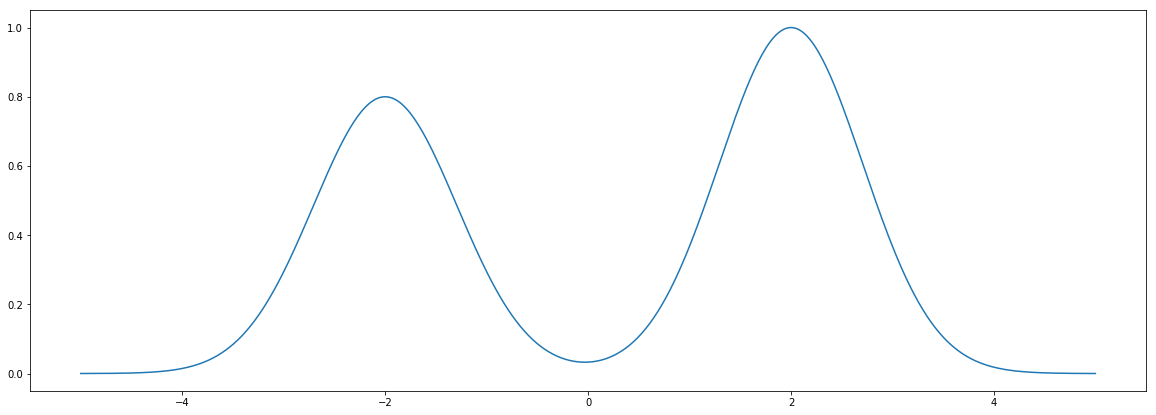

In [7]:
S = lambda x: np.exp(-(x-2)**2) + 0.8 * np.exp(-(x+2)**2)
xGrid = np.linspace(-5, 5, 500)
plt.plot(xGrid, S(xGrid));

# Iteration 1

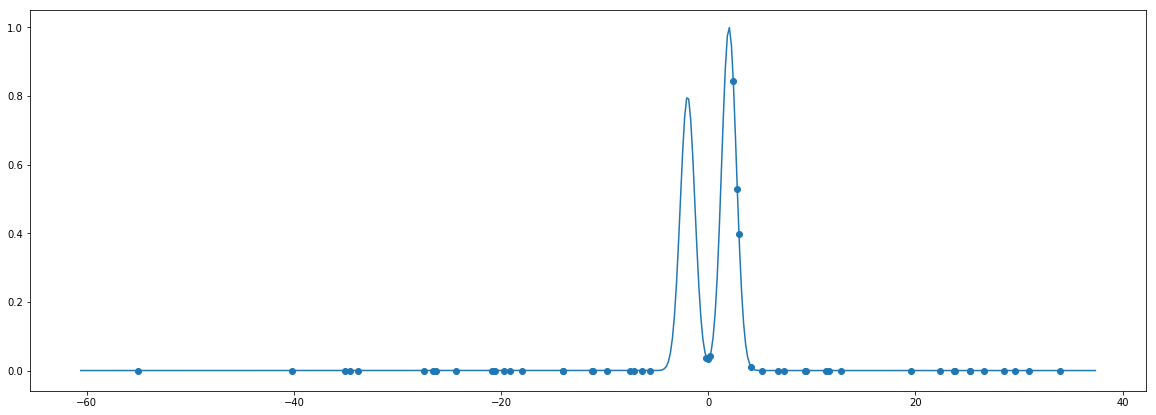

In [37]:
mu = 0; sigma = 20; R = 50; rho = 0.1; rnd.seed(1337)

Xs = stats.norm(mu, sigma).rvs(R)
xGrid = np.linspace(min(-5, Xs.min()*1.1), max(5, Xs.max()*1.1), 500)
plt.plot(xGrid, S(xGrid)); plt.scatter(Xs, S(Xs));

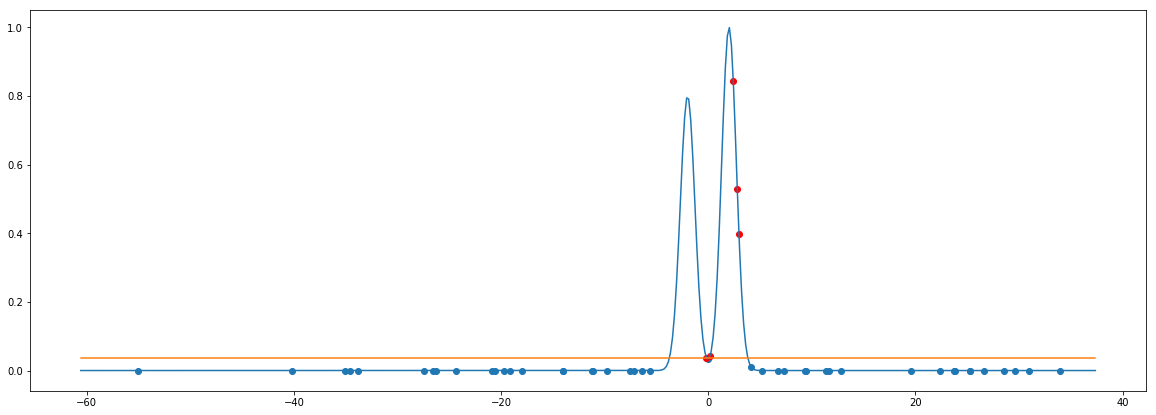

In [38]:
gamma_i = np.quantile(S(Xs), 1-rho)
elites = Xs[S(Xs) > gamma_i]; plebians = Xs[S(Xs) <= gamma_i]

plt.plot(xGrid, S(xGrid))
plt.plot([min(xGrid), max(xGrid)], [gamma_i, gamma_i])

plt.scatter(plebians, S(plebians))
plt.scatter(elites, S(elites), color="r");

mu = elites.mean(); sigma = elites.std()

## Iteration 2

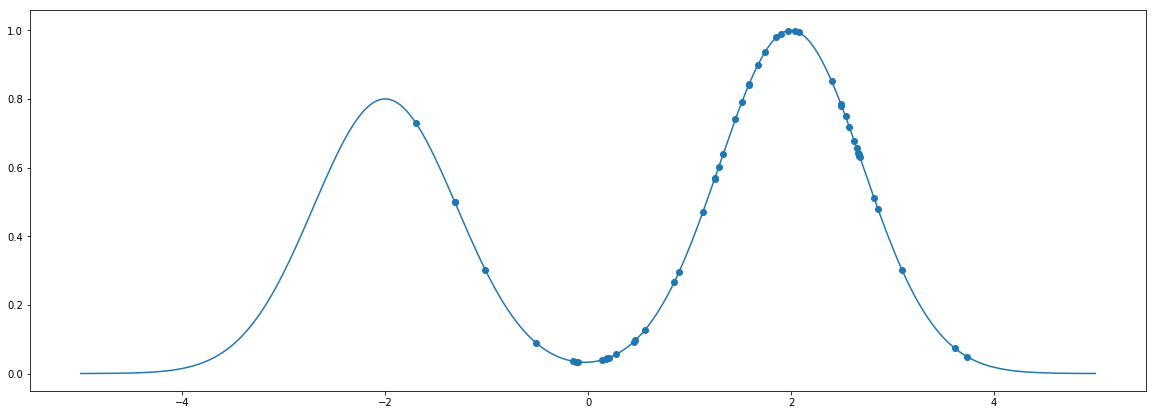

In [39]:
Xs = stats.norm(mu, sigma).rvs(R)
xGrid = np.linspace(min(-5, Xs.min()*1.1), max(5, Xs.max()*1.1), 500)
plt.plot(xGrid, S(xGrid)); plt.scatter(Xs, S(Xs));

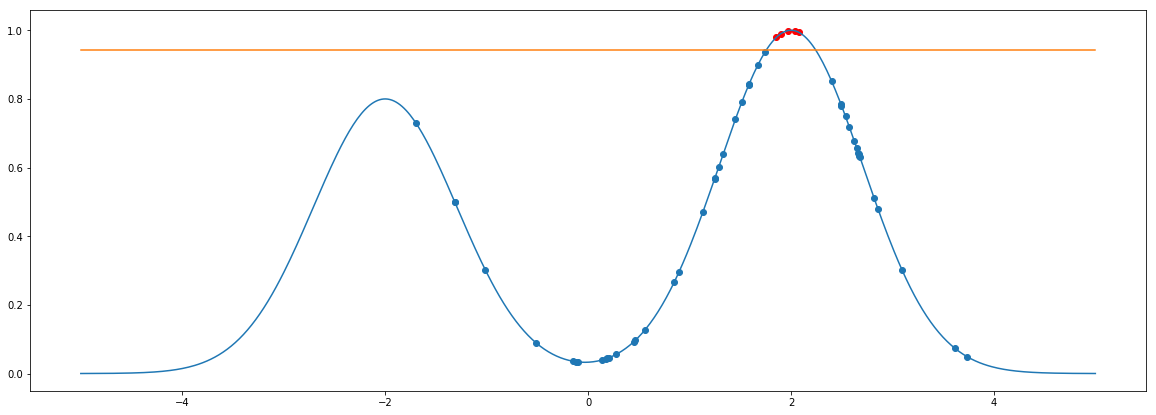

In [40]:
gamma_i = np.quantile(S(Xs), 1-rho)
elites = Xs[S(Xs) > gamma_i]
plebians = Xs[S(Xs) <= gamma_i]

plt.plot(xGrid, S(xGrid))
plt.plot([xGrid.min(), xGrid.max()], [gamma_i, gamma_i])

plt.scatter(plebians, S(plebians));
plt.scatter(elites, S(elites), color="r");

mu = elites.mean()
sigma = elites.std()

## Iteration 3

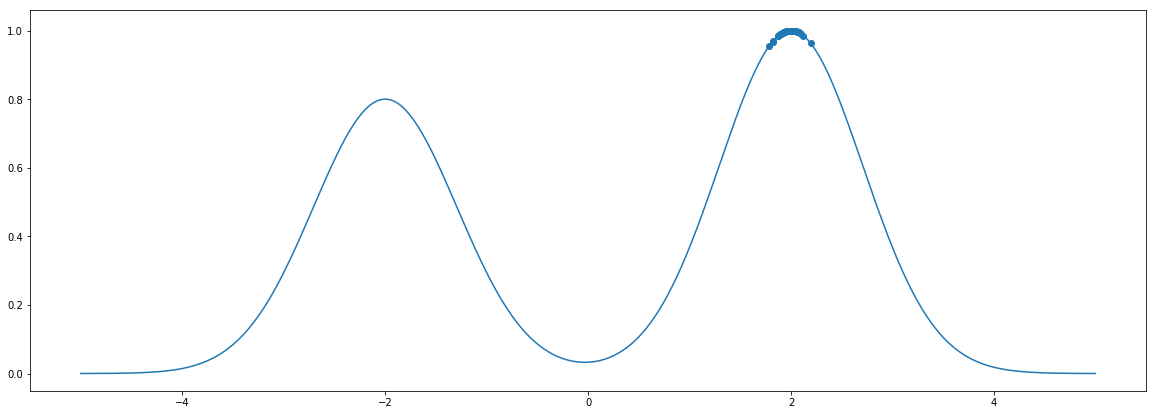

In [41]:
Xs = stats.norm(mu, sigma).rvs(R)
xGrid = np.linspace(min(-5, Xs.min()*1.1), max(5, Xs.max()*1.1), 500)
plt.plot(xGrid, S(xGrid))
plt.scatter(Xs, S(Xs));

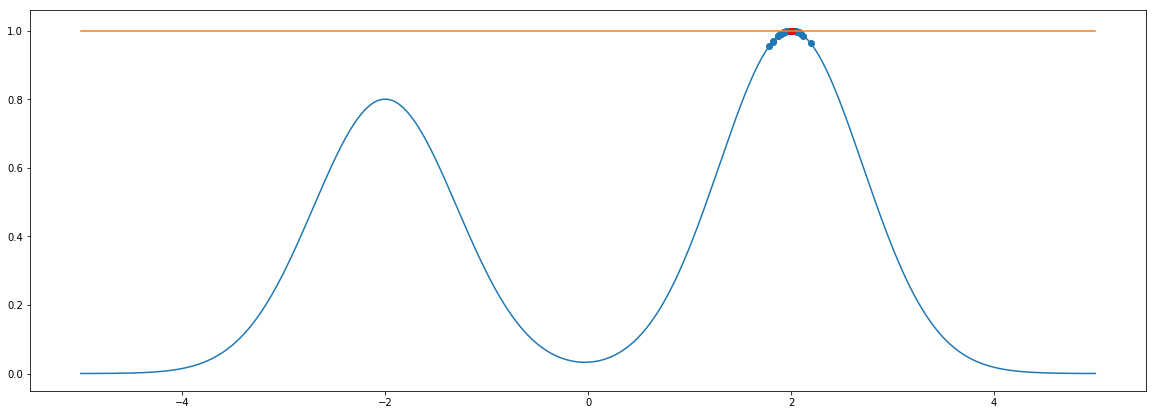

In [42]:
gamma_i = np.quantile(S(Xs), 1-rho)
elites = Xs[S(Xs) > gamma_i]
plebians = Xs[S(Xs) <= gamma_i]

plt.plot(xGrid, S(xGrid))
plt.plot([xGrid.min(), xGrid.max()], [gamma_i, gamma_i])

plt.scatter(plebians, S(plebians));
plt.scatter(elites, S(elites), color="r")

mu = elites.mean(); sigma = elites.std()

## Iteration 4

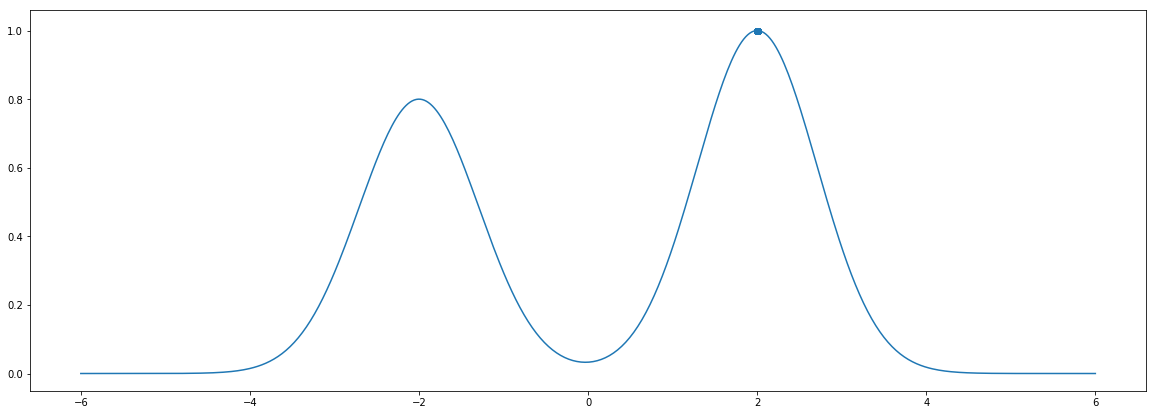

In [43]:
Xs = stats.norm(mu, sigma).rvs(R)
xGrid = np.linspace(min(-6, Xs.min()*1.1), max(6, Xs.max()*1.1), 500)
plt.plot(xGrid, S(xGrid))
plt.scatter(Xs, S(Xs));

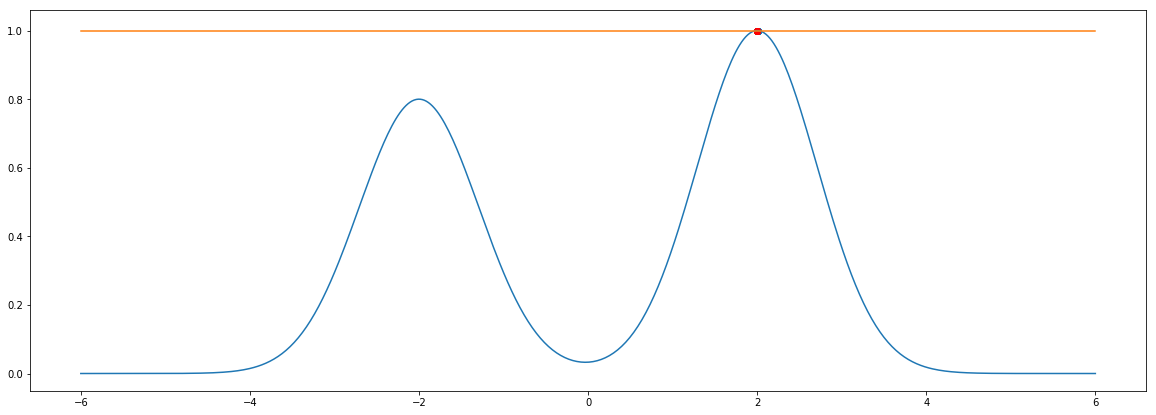

In [44]:
gamma_i = np.quantile(S(Xs), 1-rho)
elites = Xs[S(Xs) > gamma_i]
plebians = Xs[S(Xs) <= gamma_i]

plt.plot(xGrid, S(xGrid))
plt.plot([xGrid.min(), xGrid.max()], [gamma_i, gamma_i])

plt.scatter(plebians, S(plebians));
plt.scatter(elites, S(elites), color="r");

## Example: Rastrigin's function

Minimise

$$ S(\boldsymbol{x}) = 30 + \bigl( x_1^2 - 10 \cos(2\pi x_1) \bigr) + \bigl( x_2^2 - 10 \cos(2\pi x_2) \bigr) .$$

Choose the family of bivariate normal distributions, i.e.

$$f(x; v_i) = f(x; (\mu_i, \Sigma_i)) = (2\pi)^{-1} \Sigma_i^{-1/2} \exp \left\{ -\frac{1}{2} (x-\mu_i)^{\top} \Sigma_i^{-1} (x-\mu_i) \right\}.$$

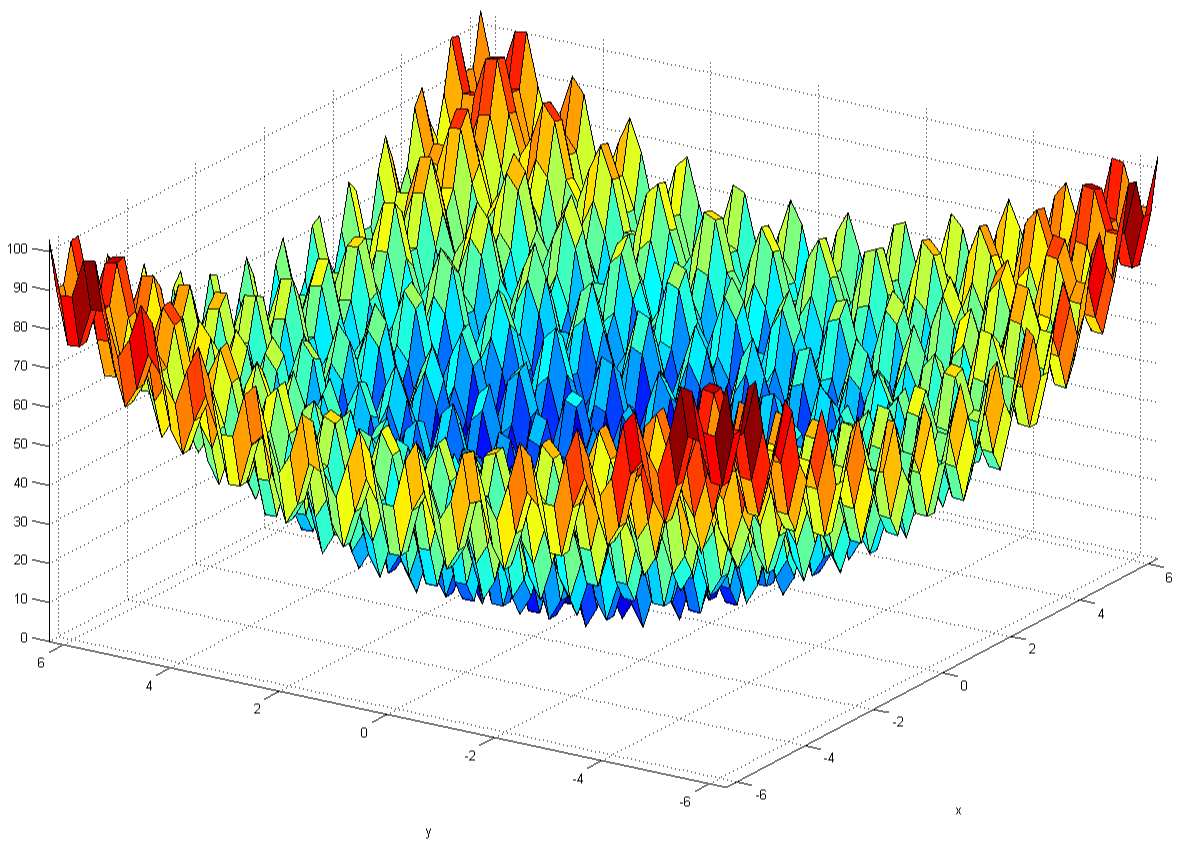

In [20]:
Image(filename="images/rastrigin.png")

## CE Progress

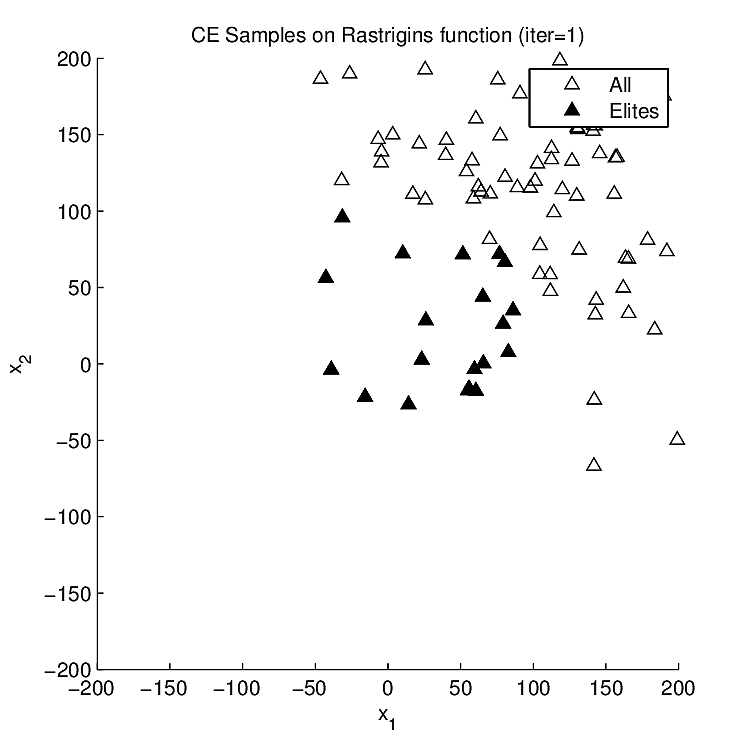

In [9]:
Image("images/rast.gif.png")

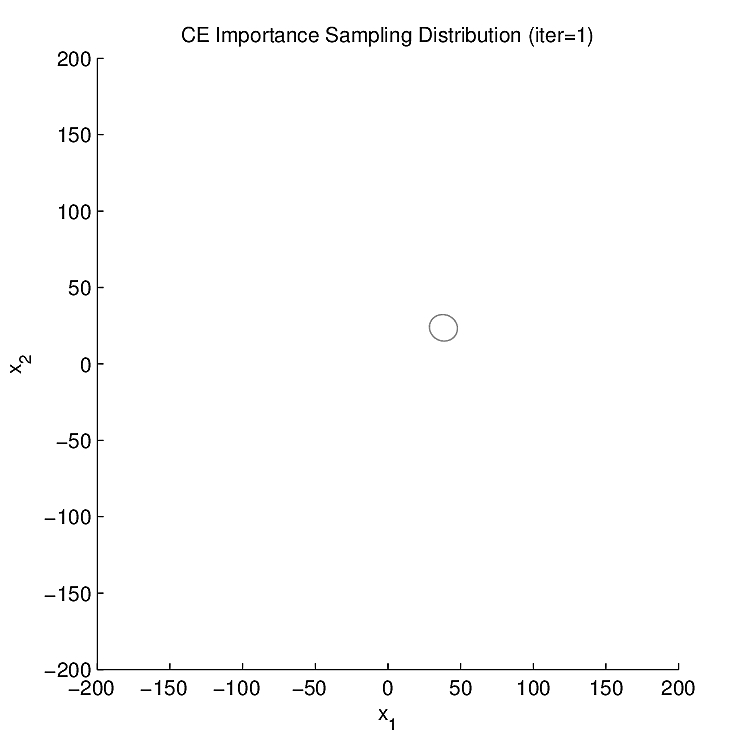

In [10]:
Image("images/rastImpDens.gif.png")

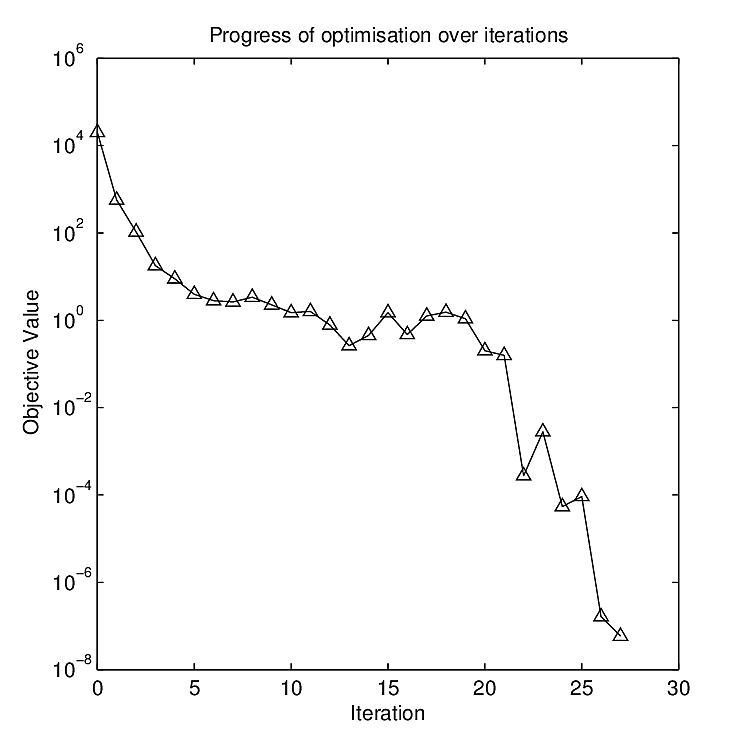

In [23]:
Image("images/progress2.jpg")

## Hidden difficulties with CE

- Can be hard to think of a family of distributions to use
- For a given family, it can be hard to simulate from those distributions

## Consider the family made by exponential tilting

Common technique for IS is to use _exponential tilting_. For a p.d.f. $f(x)$ the exponentially tilted p.d.f. is

$$ f(x; \theta) 
= \frac{\mathrm{e}^{\theta x} f(x)}{ M(\theta)}
$$

where $M(t) = \mathbb{E}[ \mathrm{e}^{t X}] = \int \mathrm{e}^{t y} f(y) \,\mathrm{d} y$.

E.g. $\mathsf{Gamma}(r, m)$ distribution: has p.d.f. $ f(x) = x^{r-1} \mathrm{e}^{-\frac{x}{m}} / (\Gamma(r) m^r )$ and moment generating function

$$ 
\begin{aligned}
M(t) = \mathbb{E}[ \mathrm{e}^{t X}]
&= \int_0^\infty \mathrm{e}^{t x} \frac{x^{r-1} \mathrm{e}^{-\frac{x}{m}}} {\Gamma(r) m^r } \,\mathrm{d} x
= \int_0^\infty \frac{ x^{r-1} \mathrm{e}^{ -\frac{ x }{ m / (1-t) } }  }{\Gamma(r) m^r }  \,\mathrm{d} x \cdot \frac{(1-mt)^r}{(1-mt)^r} \\
&= (1-mt)^{-r} \int_0^\infty \frac{ x^{r-1} \mathrm{e}^{ -\frac{ x }{ m / (1-mt) } }  }{\Gamma(r) \bigl[ \frac{m}{(1-mt)} \bigr]^r }  \,\mathrm{d} x 
= (1-mt)^{-r} , \quad t > \frac1m.
\end{aligned}
$$


## Exponentially tilted gamma distributions

P.d.f. $ f(x) = x^{r-1} \mathrm{e}^{-\frac{x}{m}} / (\Gamma(r) m^r )$, m.g.f. $M(t) = (1-mt)^{-r}$ for $t > \frac1m$, tilted p.d.f. $ f(x; \theta) = \frac{\mathrm{e}^{\theta x} f(x)}{ M(\theta)}$.

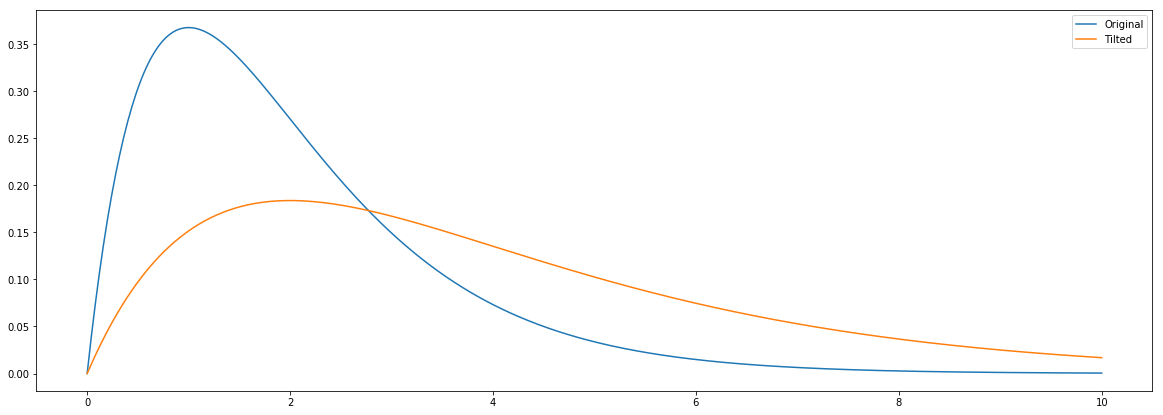

In [24]:
r = 2; m = 1; theta = 0.5;  M_theta = (1 - m*theta)**(-r) #theta = -0.5, 0.5, 1.5
x = np.linspace(0, 10, 500); f = stats.gamma(r, scale=m).pdf(x); fTilt = np.exp(theta*x) * f  / M_theta
plt.plot(x, f, x, fTilt); plt.legend(["Original", "Tilted"]);

## Simplifying exponentially tilted distributions

P.d.f. $ f(x) = x^{r-1} \mathrm{e}^{-\frac{x}{m}} / (\Gamma(r) m^r )$, m.g.f. $M(t) = (1-mt)^{-r}$ for $t > \frac1m$, tilted p.d.f. $ f(x; \theta) = \frac{\mathrm{e}^{\theta x} f(x)}{ M(\theta)}$.

With $\tilde{m}(\theta) := \frac{m}{(1-m\theta)}$, then

$$ f(x; \theta) 
= \frac{\mathrm{e}^{\theta x} x^{r-1} \frac{ \mathrm{e}^{-\frac{x}{m}} }{ \Gamma(r) m^r } }{(1-m\theta)^{-r}} 
= \frac{ x^{r-1} \mathrm{e}^{-\frac{x}{\tilde{m}(\theta)}} }{ \Gamma(r) \tilde{m}(\theta)^r } .
$$

So, $\mathsf{Gamma}(r,m)$ tilted by $\theta$ is $\mathsf{Gamma}(r,\frac{m}{1-m\theta})$. __Not really a new family of distributions at all!__ 


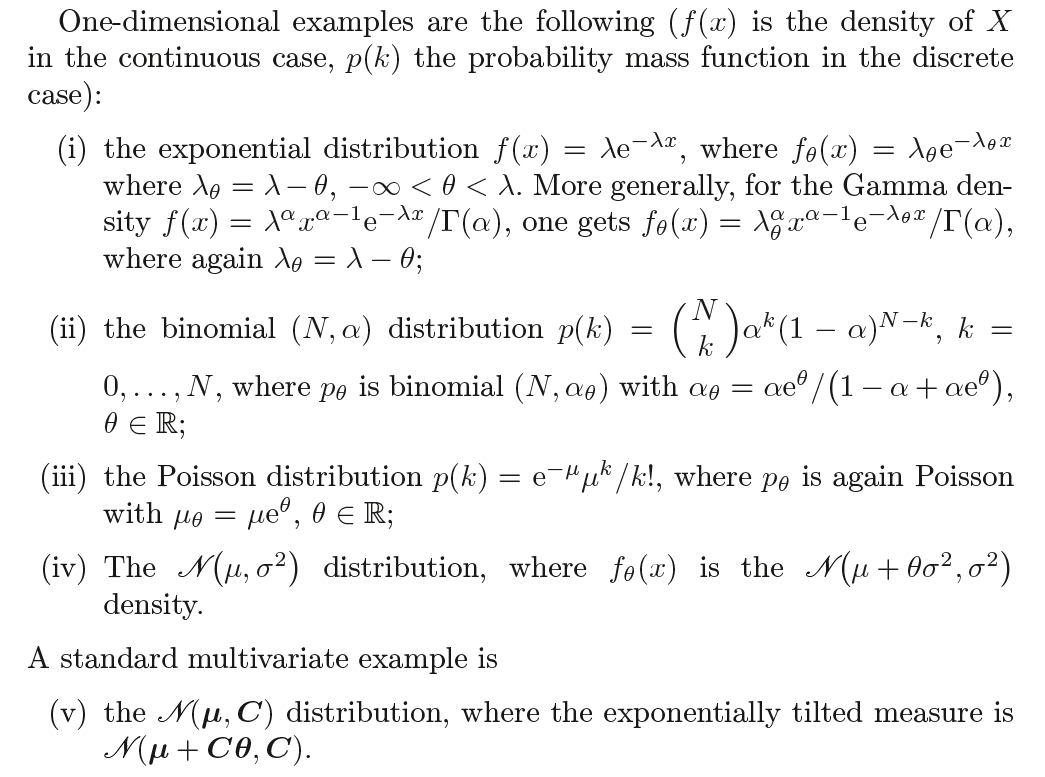

In [25]:
Image("images/Asmussen_Glynn_p_130.png")

<sub>Source: Asmussen and Glynn (2007), _Stochastic Simulation_, Springer, p. 130.</sub>

## Exponential tilting notes

$$ f(x; \theta) 
= \frac{\mathrm{e}^{\theta x} f(x)}{ M(\theta)}
$$

For $\theta > 0$ we _increase_ the likelihood of large values, and for $\theta < 0$ we _decrease_ the likelihood of large values. 

What's the largest $\theta$ we can choose? Need to ensure $M(\theta) < \infty$, so

$$ \overline{\theta} := \sup \{ \theta : M(\theta) < \infty \} .$$

If $\overline{\theta} > 0$, then $f(x)$ is a _light tailed distribution_, and we can use exponential tilting with a positive $\theta$. E.g. exponential, geometric, gamma, Gumbel, normal, Poisson, Wald, Weibull (with shape parameter $\ge 1$).

If $\overline{\theta} = 0$, then $f(x)$ is a _heavy tailed distribution_, and we can't use exponential tilting with a positive $\theta$. E.g. Pareto, lognormal, Cauchy, Weibull (with shape parameter $< 1$).

## What about simulating from difficult distributions?

Example, we take the family of distributions to be the exponentially tilted (light-tailed) Weibull distributions. E.g. if $W \sim \mathsf{Weibull}(\beta, k)$ then $M(t)$ is unknown, so can't write down its p.d.f. let alone simulate from it.

<sub>What is a (light-tailed) Weibull variable? Has p.d.f. 
$f(x) = \beta (x/k)^{\beta-1} \mathrm{e}^{-(x/k)^\beta}$
where $x > 0$, $\beta > 1$, $k > 0$. 
</sub>

## Acceptance–rejection

Assume we have a distribution $f_Y$, called the _proposal distribution_, and a $C > 0$ such tha

$$
f_X(x) \le C f_Y(x) \quad \forall x \in \mathbb{R} \,.
$$
If we can sample from the proposal distribution, then we can sample $f_X$ by:

__Acceptance–rejection__

_Inputs_: $f_X$, $f_Y$, $C$  
While True  
$\quad$ $Y \sim f_Y$, $U \sim \mathsf{Unif}(0,1)$  
$\quad$ If $U \le f_X( Y ) / C f_Y( Y )$  
$\quad$ $\quad$ return $Y$  
$\quad$ End If  
End While  
End Function

Acceptance–rejection is quite general, as it works if $f_X(x)$ is substituted for $\tilde{f}_X(x) \propto f_X(x)$.

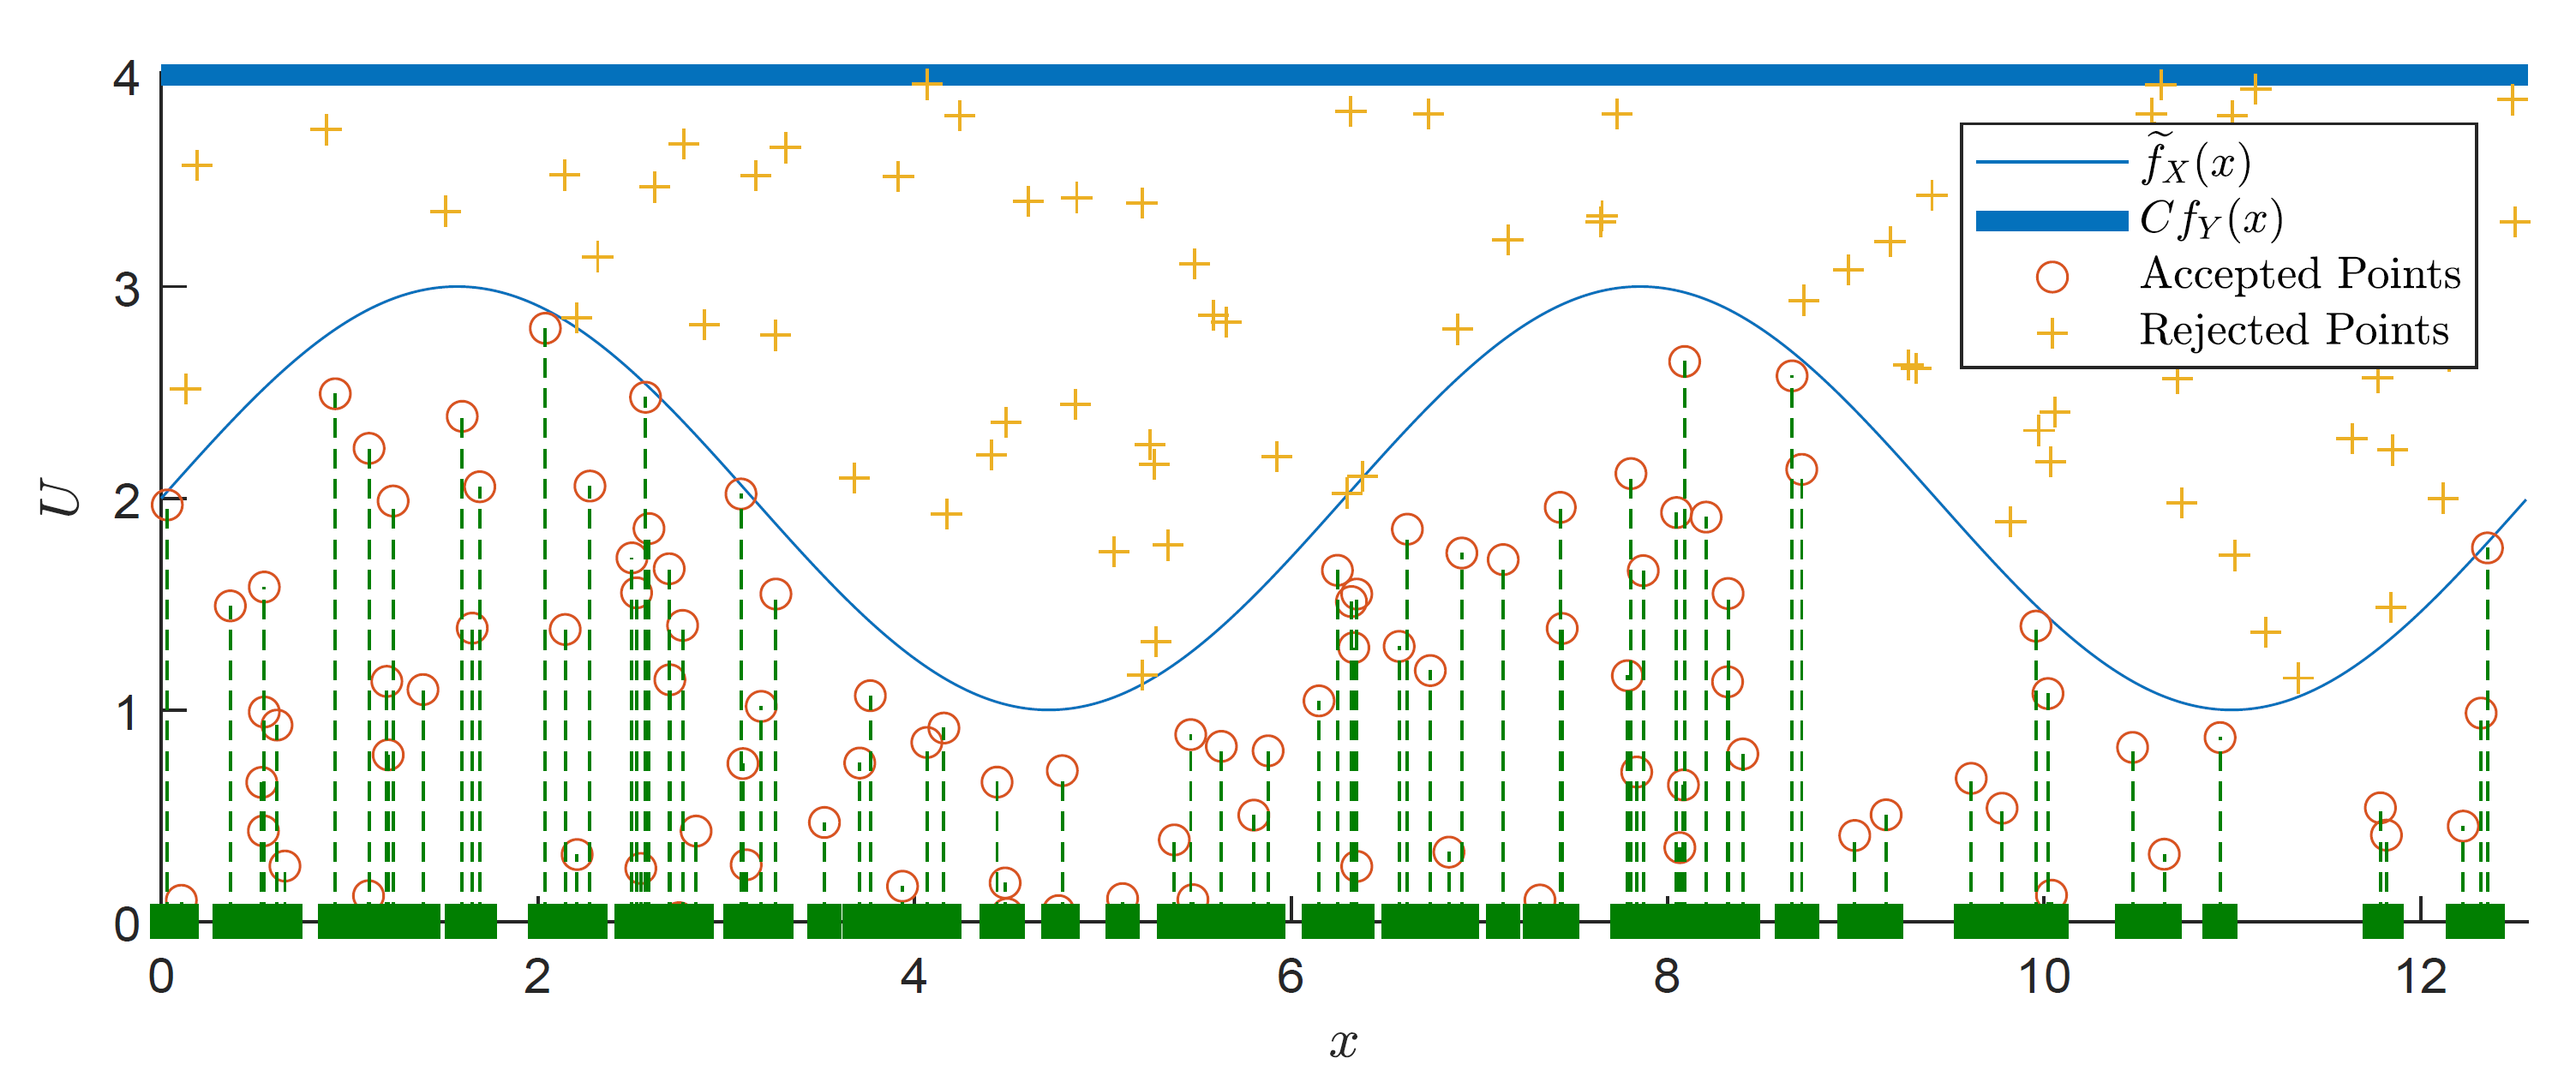

In [27]:
Image(filename="images/ar.png")

Acceptance–rejection sampling from $\tilde{f}_X(x) = 2 + \sin(x)$ for $x \in [0, 4\pi]$ using the proposal distribution $\mathsf{Unif}[0,4\pi]$, $C=16\pi$, and sampling $R=100$ random variables.

This efficiency of acceptance–rejection depends heavily upon the constant $C$. If we use $f_X$ and not $\tilde{f}_X$ above (i.e. we know the normalising constant of the desired distribution) then $C$ can be easily interpreted. That is, the expected number of samples from $f_Y$ needed to accept one sample from $f_X$ is $1 / C$. So the optimal value of $C$ is 1; then, we never generate proposal samples which are wastefully discarded.

Determining $C$ can be laboriously done by hand, or it can be the result of a root-finding algorithm. Extending to $d>1$ dimensions is possible, but the determination of $C$ becomes even more difficult.

## Simulate from a distribution using Markov chains

Discrete time process $(X_n)_{n \ge 0}$, where $X_n \in \mathbb{R}$, with the _Markov property_:

$$ \mathbb{P}(X_n \in A \mid X_0 = x_0, X_1 = x_1, \dots, X_{n-1} = x_{n-1}) = \mathbb{P}(X_n \in A \mid X_{n-1} = x_{n-1}) $$

for $A \in \mathcal{B}(\mathbb{R})$. 

## Markov chain-related distributions

For example, _phase-type distributions_: https://youtu.be/8Ih2NxrLrmg

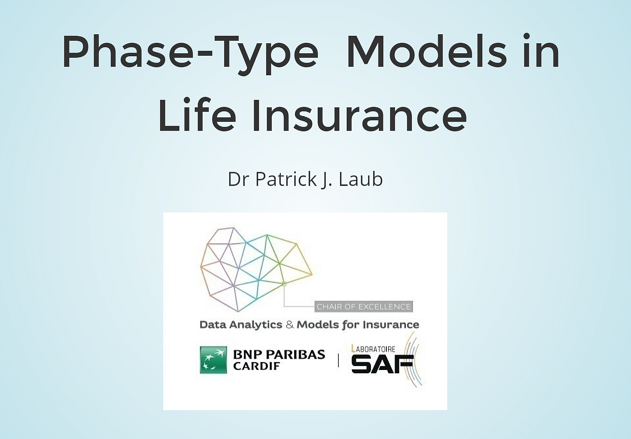

In [28]:
Image(filename="images/phase-type-talk.png")

## Stationary distributions.

Some MCs have a stationary distribution, $\pi(\,\cdot\,)$, so if

$$ X_0 \sim \pi(\,\cdot\,) \quad\Rightarrow\quad X_1 \sim \pi(\,\cdot\,) \quad\Rightarrow\quad X_2 \sim \pi(\,\cdot\,) \dots $$

If we want to simulate from $\pi(\,\cdot\,)$, we can generate

$$ X_1, \dots, X_R \overset{\mathrm{i.d.}}{\sim} \pi(\,\cdot\,) $$

so long as we can generate the first $X_0$ somehow.

## All roads lead to Rome

Some MCs have a limiting distribution, that is, for all starting positions $x_0 \in \mathbb{R}$ as $n \to \infty$

$$ (X_n \mid X_0 = x_0) \overset{\mathcal{D}}{\longrightarrow} \, \pi(\,\cdot\,) .$$

The limiting distribution $\pi$ is the stationary distribution (at least, normally).

So... if we want to simulate from $\pi$, just start $X_0$ anywhere, run the Markov chain for $n = \infty$ time, then we have

$$ X_{\infty} \sim \pi(\,\cdot\,) \quad\Rightarrow\quad X_{\infty+1} \sim \pi(\,\cdot\,) \quad\Rightarrow\quad X_{\infty+2} \sim \pi(\,\cdot\,) \dots$$

Or, more realistically, just start $X_0$ anywhere and run this for _a while_, then after $N \approx \infty$ we have

$$ X_{N} \overset{\mathrm{approx.}}{\sim} \pi(\,\cdot\,) \quad\Rightarrow\quad X_{N+1} \overset{\mathrm{approx.}}{\sim} \pi(\,\cdot\,) \quad\Rightarrow\quad X_{N+2} \overset{\mathrm{approx.}}{\sim} \pi(\,\cdot\,) \dots$$

## A very strange Markov chain example

Given $X_{i-1} = x_{i-1}$, how to get the next $X_i$?

Sample $E_i \sim \mathsf{Exponential}(\lambda)$ and either _jump left_ taking $X_i = x_{i-1} - E_i$ or _jump right_ taking $X_i = x_{i-1} + E_i$.

What are the rules for jumping left or right? 

- If $x_{i-1} < -1$ we jump right
- If $x_{i-1} > 1$ we jump left. 
- If $x_{i-1} \in (-1, 1)$ we jump left with probability 
$$ \frac{ \frac{1}{(x+1)^2} }{ \frac{1}{(x+1)^2} + \frac{1}{(x-1)^2} } .$$

## R to generate a transition

Given $X_{i-1} = x_{i-1}$, how to get the next $X_i$?

Sample $E_i \sim \mathsf{Exponential}(\lambda)$ and either _jump left_ taking $X_i = x_{i-1} - E_i$ or _jump right_ taking $X_i = x_{i-1} + E_i$.

What are the rules for jumping left or right? 

- If $x_{i-1} < -1$ we jump right
- If $x_{i-1} > 1$ we jump left. 
- If $x_{i-1} \in (-1, 1)$ we jump left with probability 

$$ \frac{ \frac{1}{(x+1)^2} }{ \frac{1}{(x+1)^2} + \frac{1}{(x-1)^2} } .$$

In [2]:
%%R

lambda <- 5

rtransition <- function(x) { 

    E <- rexp(1, lambda)
    
    probJumpLeft <- (1 / (x+1)^2) / 
        ((1 / (x+1)^2) + (1 / (x-1)^2))

    if (x > 1) {
        return( x - E )
    }
    if (x < -1) {
        return( x + E )
    }
    
    if (runif(1) < probJumpLeft) {
        return( x - rexp(1, lambda) )
    } else {
        return( x + rexp(1, lambda) )
    }
}

rtransition(0)

[1] 0.2988769


## Plot transition densities

In [3]:
%%R

dtransition <- function(y, x) { 
    
    leftJump <- dexp( -(y-x), lambda )
    rightJump <- dexp( (y-x), lambda )
    
    if (x < -1) {
        return(rightJump)
    } 
    if (x > 1) {
        return(leftJump)
    }
    
    probJumpLeft <- (1 / (x+1)^2) / 
        ((1 / (x+1)^2) + (1 / (x-1)^2))
    
    return(probJumpLeft*leftJump + (1-probJumpLeft)*rightJump)
}

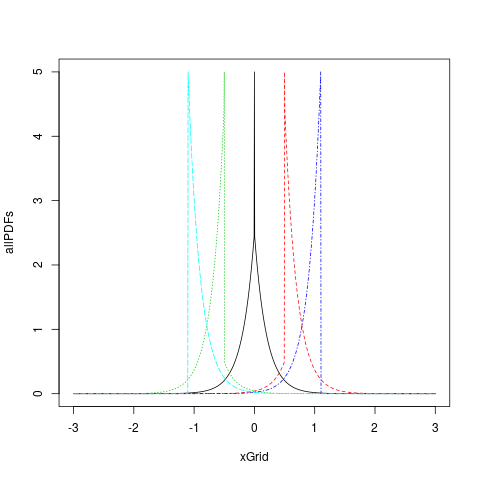

In [4]:
%%R 

xGrid <- seq(-3, 3, 0.005)

pdfs <- c(dtransition(xGrid, 0))
pdfs <- c(pdfs, dtransition(xGrid, 0.5))
pdfs <- c(pdfs, dtransition(xGrid, -0.5))
pdfs <- c(pdfs, dtransition(xGrid, 1.1))
pdfs <- c(pdfs, dtransition(xGrid, -1.1))

allPDFs <- matrix(pdfs, ncol=5)
matplot(xGrid, allPDFs, type="l")

## And vectorise the transition simulation

In [5]:
%%R

lambda <- 5

rtransition <- function(x) { 

    E <- rexp(1, lambda)
    
    probJumpLeft <- (1 / (x+1)^2) / 
        ((1 / (x+1)^2) + (1 / (x-1)^2))

    if (x > 1) {
        return( x - E )
    }
    if (x < -1) {
        return( x + E )
    }
    
    if (runif(1) < probJumpLeft) {
        return( x - rexp(1, lambda) )
    } else {
        return( x + rexp(1, lambda) )
    }
}

rtransition(0)

[1] -0.1183161


In [6]:
%%R

rtransitionVectorised <- function(x) { 
    
    R <- length(x)
    
    Es <- rexp(R, lambda)
    
    probJumpLeft <- (1 / (x+1)^2) / 
        ((1 / (x+1)^2) + (1 / (x-1)^2))
    
    jumpLeft <- (runif(R) < probJumpLeft)
    jumpLeft[which(x < -1)] <- FALSE
    jumpLeft[which(x > 1)] <- TRUE
    
    jumpSizes <- (-1)^jumpLeft * Es
    
    return(x + jumpSizes)
}

rtransitionVectorised(c(-1.5, 0, 1.5))

[1] -1.09121579  0.05566258  1.35715524
